# Pathology LN_mestasis classification 8/3 (2d)

# Medical Image Classification Tutorial with the MedNIST Dataset

In this tutorial, we introduce an end-to-end training and evaluation example based on the MedNIST dataset.

We'll go through the following steps (앞으로의 과정을 통해 할 것):

1. Create a dataset for training and testing (training 과 test를 위한 데이터셋 만들기)
2. Use MONAI transforms to pre-process data (데이터 전처리를 위해MONAI transforms를 사용)
3. Use the DenseNet from MONAI for classification (classification을 위해 MONAI로부터 DensNet 사용)
4. Train the model with a PyTorch program (PyTorch program을 통해 모델 학습)
5. Evaluate on test dataset (test dataset으로 평가)

# Setup environment

tqdm 는 즉석에서 progress bar 를 생성해주고, 함수나 반복문의 TTC (Time To Completion) 를 예측하는 파이썬 패키지를 말한다.

monai-weekly는 AI TOOLKIT for Healthcare Imaging, 추가기능지원을 위해 추가 구문 사용

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [ ]:
import monai

# Setup imports

In [ ]:

# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    EnsureType,
)
from monai.utils import set_determinism

print_config()

MONAI version: 0.7.dev2131
Numpy version: 1.19.5
Pytorch version: 1.9.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 57467c75bff90e6c9da74461f7da3a828a39626b

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.16.2
Pillow version: 7.1.2
Tensorboard version: 2.5.0
gdown version: 3.6.4
TorchVision version: 0.10.0+cu102
tqdm version: 4.62.0
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.1.5
einops version: 0.3.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [ ]:
!pip install einops

# Setup data directory

You can specify a directory with the MONAI_DATA_DIRECTORY environment variable.
This allows you to save results and reuse downloads.
If not specified a temporary directory will be used.

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY") #Python에서os.environ.get()함수를 사용하여 환경 변수 가져 오기
root_dir = tempfile.mkdtemp() if directory is None else directory #directory가 None이면 임시 디렉토리 생성하고 그것의 경로를 root_dir에 저장하라.
print(root_dir)

/tmp/tmpw_0r55ic


# Download dataset

The MedNIST dataset was gathered from several sets from TCIA, the RSNA Bone Age Challenge, and the NIH Chest X-ray dataset.

The dataset is kindly made available by Dr. Bradley J. Erickson M.D., Ph.D. (Department of Radiology, Mayo Clinic) under the Creative Commons CC BY-SA 4.0 license.

If you use the MedNIST dataset, please acknowledge the source.

(MedNIST 데이터 세트는 TCIA, RSNA Bone Age Challenge 및 NIH 흉부 X선 데이터 세트에서 수집되었습니다.

데이터셋은 Creative Commons CC BY-SA 4.0 라이센스로 Bradley J. Ericson M.D., Ph.D(Department of Radiology, Mayo Clinic)에 의해 제공됩니다.

MedNIST 데이터 집합을 사용하는 경우 소스를 확인하십시오.)

In [ ]:
resource = "https://drive.google.com/uc?id=1QsnnkvZyJPcbRoV_ArW8SnE1OTuoVbKE"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz") #인수에 전달된 2개의 문자열을 결합하여, 1개의 경로로 설정
data_dir = os.path.join(root_dir, "MedNIST") 
if not os.path.exists(data_dir):  # 지정된 경로가 존재하는지 여부를 확인하는데 사용
    download_and_extract(resource, compressed_file, root_dir, md5) #resource에서 root_dir에 저장하고 압축풀기
    #MD5(Message-Digest algorithm 5)는 128비트 암호화 해시 함수이다.

Downloading...
From: https://drive.google.com/uc?id=1QsnnkvZyJPcbRoV_ArW8SnE1OTuoVbKE
To: /tmp/tmp2pz61myo/MedNIST.tar.gz
61.8MB [00:00, 117MB/s]


Downloaded: /tmp/tmpw_0r55ic/MedNIST.tar.gz
Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
Writing into directory: /tmp/tmpw_0r55ic.


# Set deterministic training for reproducibility

재현성에 대한 결정론적 training 설정

In [ ]:
set_determinism(seed=0) # 결과가 계속 랜덤하게 바뀌니까 돌릴 때마다 결과가 일정하게 나오도록 컴퓨터가 랜덤
#중요
# pseudorandom 컴퓨터에서 random variable을 발생시키는 건 이미 있는 수식을 통해 만들어지는 거임 seed값을 시간이나 날짜를 통해 정하게 해서 랜덤하게 보이도록 하는 것.

# Read image filenames from the dataset folders

First of all, check the dataset files and show some statistics.
There are 6 folders in the dataset: Hand, AbdomenCT, CXR, ChestCT, BreastMRI, HeadCT,
which should be used as the labels to train our classification model.

먼저 데이터 집합 파일을 확인하고 일부 통계를 표시합니다. 데이터 세트에는 다음과 같은 6개의 폴더가 있습니다. Hand, Abdomen CT, CXR, ChestCT, BreastMRI, HeadCT, 이 라벨은 당사의 분류 모델을 training하는 데 사용됩니다.

Abdomen : 복부
Breast : 흉부
CXR : chest X-ray
ChestCT : chest CT
Hand : 손
Head CT : 머리 CT

Data 형식 : jpeg (64 * 64)

In [ ]:
data_dir = "/content/drive/MyDrive/pathology/Data/class"

In [ ]:
# listdir : 디렉토리 내의 [모든 파일과 디렉토리의 폴더명] 리스트를 리턴한다
# parameters = 디렉토리의 path
#os.path.isdir() : 폴더 유무 판단
#입력된 경로가 폴더인지 아닌지 판별해준다
#밑에 코드가 하는 것은 경로로부터 디렉토리들을 추출하여 리스트로 만든다
class_names = sorted(x for x in os.listdir(data_dir)
                     if os.path.isdir(os.path.join(data_dir, x)))

num_class = len(class_names) # num_class = 3

# class 디렉토리마다 저장되어있는 모든 파일의 경로를 추출하여 class
#마다 list로 만든다.
image_files = [
    [
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i])) #밑에 for문이랑 아래 for문 몇번도는지 숙제
    ]
    for i in range(num_class)
] 
# 각 class에 대한 이미지파일의 개수를 num_each에 저장
num_each = [len(image_files[i]) for i in range(num_class)]

image_files_list = []
image_class = []

for i in range(num_class):
    image_files_list.extend(image_files[i]) #image_files_list 에 모든 파일 경로 넣음 
    image_class.extend([i] * num_each[i]) #각 class에 데이터 개수 만큼 클래스를 입력
num_total = len(image_class) # 이미지의 전체 개수 저장

# 첫번째 이미지를 열어서 size를 추출하여 넓이와 높이를 추출
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 491
Image dimensions: 705 x 553
Label names: ['abnormal', 'black', 'normal']
Label counts: [177, 169, 145]


In [ ]:
image_files_list[200:235]

['/content/drive/MyDrive/pathology/Data/class/black/Image152.png',
 '/content/drive/MyDrive/pathology/Data/class/black/Image155.png',
 '/content/drive/MyDrive/pathology/Data/class/black/Image157.png',
 '/content/drive/MyDrive/pathology/Data/class/black/Image15.png',
 '/content/drive/MyDrive/pathology/Data/class/black/Image145.png',
 '/content/drive/MyDrive/pathology/Data/class/black/Image142.png',
 '/content/drive/MyDrive/pathology/Data/class/black/Image148.png',
 '/content/drive/MyDrive/pathology/Data/class/black/Image147.png',
 '/content/drive/MyDrive/pathology/Data/class/black/Image14.png',
 '/content/drive/MyDrive/pathology/Data/class/black/Image141.png',
 '/content/drive/MyDrive/pathology/Data/class/black/Image146.png',
 '/content/drive/MyDrive/pathology/Data/class/black/Image143.png',
 '/content/drive/MyDrive/pathology/Data/class/black/Image144.png',
 '/content/drive/MyDrive/pathology/Data/class/black/Image140.png',
 '/content/drive/MyDrive/pathology/Data/class/black/Image135.png

# Randomly pick images from the dataset to visualize and check
(데이터 셋에서 이미지를 임의로 선택하여 시각화 및 확인)

np.random.randint(2, size=5)는 [0, 2) 범위에서 다섯개의 임의의 정수를 생성합니다.

np.random.randint(2, 4, size=5)는 [2, 4) 범위에서 다섯개의 임의의 정수를 생성합니다.

np.random.randint(1, 5, size=(2, 3))는 [1, 5) 범위에서 (2, 3) 형태의 어레이를 생성합니다.

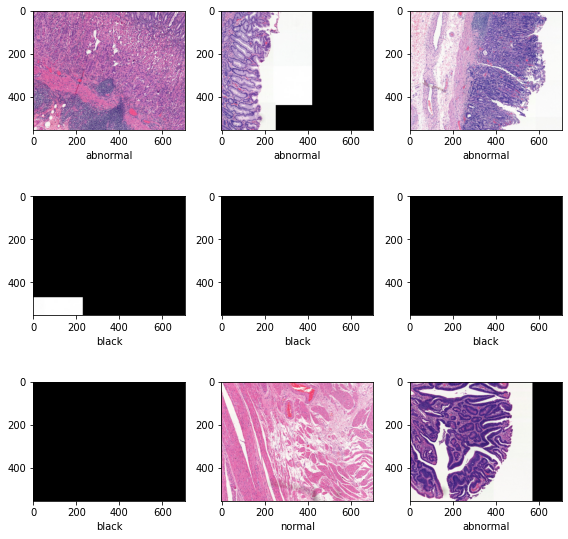

In [ ]:
# 3 * 3 subplot을 만든다, figsize(가로길이,세로길이) 단위=inch
plt.subplots(3, 3, figsize=(8, 8))

# 0에서 num_total(58953) 까지 랜덤한 숫자 1개 뽑아내기 size = 9 by 1
for i, k in enumerate(np.random.randint(num_total, size=9)):
    # k번째 해당하는 이미지를 열어 im에 저장
    im = PIL.Image.open(image_files_list[k])
    # 이미지를 numpy의 ndarray로 만듬
    arr = np.array(im) 
    # 그래프를 띄우는 것
    plt.subplot(3, 3, i + 1)
    #  label text를 써줌
    plt.xlabel(class_names[image_class[k]])
    # nd array 형태로 만들어진 이미지를 출력
    plt.imshow(arr,  vmin=0, vmax=255)
plt.tight_layout() # 자동으로 명시된 여백(padding)에 관련된 서브parameter를 조정한다. 입력없이 사용할 경우 기존에 세팅된 기본값을 이용하여 자동으로 레이아웃을 설정
 # 수치를 표시 imshow는 이미지를 그림
plt.show()
#imShow() 함수는 이미지 처리 및 형식 표시를 담당하며, plt. show()는 plt.imShow()로 처리된 함수를 표시합니다.

# Prepare training, validation and test data lists 
(traning, validation 및 테스트 데이터 리스트 준비)

Randomly select 10% of the dataset as validation and 10% as test.


(데이터 집합의 10%를 검증으로, 10%를 테스트로 무작위로 선택합니다)

In [ ]:
val_frac = 0.1
test_frac = 0.1
length = len(image_files_list) #전체 데이터의 수
indices = np.arange(length) # ndarray를 생성 length=3이면 array([0,1,2])
np.random.shuffle(indices) #배열순서를 random하게 섞음

test_split = int(test_frac * length) #전체데이터수의 10%에 해당하는 수를 저장
val_split = int(val_frac * length) + test_split #10%에 해당하는 데이터와 test data수를 합친 수를 저장  
test_indices = indices[:test_split] #0부터 test_split 수만큼 전체 원소에서 원소 추출
val_indices = indices[test_split:val_split] #testsplite의 마지막 원소부터 val_split의수 만큼의 원소를 추출
train_indices = indices[val_split:] # 나머지 인덱스에 해당하는 원소를 모두 train_indices로 저장

train_x = [image_files_list[i] for i in train_indices] #image_files_list로부터 인덱싱을 통해 train 데이터셋 추출
train_y = [image_class[i] for i in train_indices]      #imageclass로부터 train 데이터에 대한 레이블데이터 추출
val_x = [image_files_list[i] for i in val_indices]     #image_files_list로부터 인덱싱을 통해 valid 데이터셋 추출
val_y = [image_class[i] for i in val_indices]          #imageclass로부터 valid 데이터에 대한 레이블데이터 추출
test_x = [image_files_list[i] for i in test_indices]   #image_files_list로부터 인덱싱을 통해 test 데이터셋 추출
test_y = [image_class[i] for i in test_indices]        #imageclass로부터 test 데이터에 대한 레이블데이터 추출

# train,valid,test 각 데이터의 수 출력
print(
    f"Training count: {len(train_x)}, Validation count: "
    f"{len(val_x)}, Test count: {len(test_x)}")

Training count: 393, Validation count: 49, Test count: 49


# Define MONAI transforms, Dataset and Dataloader to pre-process data

( 데이터 전처리를 위해 Dataset과 Dataloader, Monai transforms를 정의)

AddChannel : 입력 이미지에 1길이 채널 차원을 추가합니다.

    ``monai.transforms``의 대부분의 이미지 변환 
    은 입력 이미지가 채널 우선 형식이라고 가정하며, 모양은 
    (num_channels, spatial_dim_1[, spatial_dim_2, ...])입니다.

    예를 들어 이 변환을 사용하여 (spatial_dim_1[, spatial_dim_2, ...]) 
    공간 이미지를 채널 우선 형식으로 
    변환 하여     다차원 이미지 배열을 다른 
변환 
에서 올바르게 해석할 수 있습니다 .     ""

In [ ]:
#AddChannel(),Adds a 1-length channel dimension to the input image.
#ScaleIntensity(),:입력 이미지의 강도를 주어진 값 범위(minv, maxv)로 조정합니다. 경우 minv 및 maxv은 하지를 사용 제공 요인 에 의해 규모의 이미지
#RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True), 인풋어레이를 랜덤하게 rotate함,probe=rotation의 확률
#RandFlip(spatial_axis=0, prob=0.5), #축을 따라 이미지를 무작위로 뒤집습니다. 모양을 유지합니다.
#RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5), #주어진 확대/축소 범위 내에서 주어진 확률로 입력 배열을 무작위로 확대합니다.
#EnsureType(),#입력 데이터가 PyTorch Tensor 또는 numpy 배열인지 확인하고 지원: numpy array , PyTorch Tensor , float , int , bool , string 및 object 는 원본을 유지합니다. 사전, 목록 또는 튜플을 전달하는 경우 여전히 사전, 목록 또는 튜플을 반환하고 모든 항목을 예상 데이터 유형으로 재귀적으로 변환합니다.

train_transforms = Compose(
    [
        LoadImage(image_only=True),
        
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5), 
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5), 
        EnsureType(),
    ]
)

val_transforms = Compose(
    [LoadImage(image_only=True), ScaleIntensity(), EnsureType()])

y_pred_trans = Compose([EnsureType(), Activations(softmax=True)])
y_trans = Compose([EnsureType(), AsDiscrete(to_onehot=True, n_classes=num_class)])

In [ ]:
# 모델에 입력하기 위한 training, validation 또는 test 데이터셋 생성하기 위한 class선언
class MedNISTDataset(torch.utils.data.Dataset): #상속함 ()안에들어있는거
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

# data_loader 정의(DataLoader = 데이터셋과 샘플러를 결합하고 사용 가능한 데이터셋을 제공합니다.)
# num_workers = 학습 도중 CPU의 작업을 몇 개의 코어를 사용해서 진행할지에 대한 설정 파라미터입니다
train_ds = MedNISTDataset(train_x, train_y,train_transforms)
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=5, shuffle=True, num_workers=10)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=5, num_workers=10)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=5, num_workers=10)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
a,b = train_ds[0]

In [ ]:
a.shape

torch.Size([1, 705, 553, 4])

# Define network and optimizer

1.Set learning rate for how much the model is updated per batch.

2.Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.
And as this is just a get start tutorial, let's just train 4 epochs.
If train 10 epochs, the model can achieve 100% accuracy on test dataset.

3.Use DenseNet from MONAI and move to GPU devide, this DenseNet can support both 2D and 3D classification tasks.

4.Use Adam optimizer.

# 네트워크와 optimizer를 정의

1.배치당 모델이 업데이트되는 양에 대한 학습 속도를 설정합니다.

2.모든 epoch의 training 데이터가 다르도록 Shuffle 및 랜덤 변환이 있으므로 총 epoch 번호를 설정합니다.
그리고 이건 시작 튜토리얼이니까 4단계만 훈련하자.
10Epoch를 훈련할 경우 이 모델은 테스트 데이터 집합에서 100% 정확도를 달성할 수 있습니다.

3.MONAI에서 DenseNet을 사용하여 GPU Devide로 이동하면, 이 DenseNet은 2D 및 3D 분류 작업을 모두 지원할 수 있습니다.

4. Adam Optimizer를 사용합니다.

In [ ]:

device = torch.device("cuda:0") # 저장한 모델을 gpu에서 불러올 때
model = DenseNet121(spatial_dims=2, in_channels=4, #DenseNet은 CNN 아키텍쳐 중 하나
                    out_channels=num_class).to(device) # out_channels = 출력 채널 수
loss_function = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), 1e-5) # learning rate
max_epochs = 3 
val_interval = 1
auc_metric = ROCAUCMetric() # AUC: ROC 곡선 아래 영역 / AUC 계산 metric

#Model training

Execute a typical PyTorch training that run epoch loop and step loop, and do validation after every epoch.
Will save the model weights to file if got best validation accuracy.

epoch 루프 및 스텝 루프를 실행하는 일반적인 PyTorch trainng을 실행하고 epoch가 끝날 때마다 validation을 한다.
최상의 validation accuracy를 얻은 경우 모델 weight를 파일에 저장합니다.

In [ ]:
print(train_loader.batch_size)

len(train_ds)


5


393

In [ ]:
print(type(train_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [ ]:
a.shape

torch.Size([705, 553, 4])

In [ ]:
root_dir = "/content/drive/MyDrive/pathology/Data/class"

In [ ]:
#epoch =3
#batchsize =5

best_metric = -1    
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs): 
    print("-" * 10)         #구분선
    print(f"epoch {epoch + 1}/{max_epochs}") #몇번째 epoch인지 출력
    model.train()           # 모델 학습
    epoch_loss = 0          # epoch_loss(epoch의 average loss) 초기화
    step = 0                # step 초기화
    for batch_data in train_loader: # train_loader에서 train데이터에 대한 정보가져옴
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        print(inputs.shape)
        inputs = inputs.reshape(inputs.shape[0], inputs.shape[3],inputs.shape[1],inputs.shape[2] )#0,3,1,2)
        print(inputs.shape)
        optimizer.zero_grad() #Pytorch에서는 gradients값들을 추후에 backward를 해줄때 계속 더해주기 때문"에 우리는 항상 backpropagation을 하기전에 gradients를 zero로 만들어주고 시작을 해야합니다
        outputs = model(inputs)
        loss = loss_function(outputs, labels) #lossfuction으로 loss 계산
        loss.backward() #현재 tensor의 gradient를 계산
        optimizer.step() #
        epoch_loss += loss.item() #train_loss 값을 epoch_loss에 더해서 저장
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "# train데이터를 batch size로 나눈 값
            f"train_loss: {loss.item():.4f}") # train loss
        epoch_len = len(train_ds) // train_loader.batch_size #epoch수 (47164 /300)
    epoch_loss /= step        # average loss는 전체 loss 값 더해준 것을 step으로 나눈 값
    epoch_loss_values.append(epoch_loss)  # epoch_loss값 리스트에 원소로 추가
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0: # epoch 한 번 돌았으면 나머지 수행
        model.eval()   # 모델 평가
        with torch.no_grad():    #gradinet 계산하지 않음
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                val_images = val_images.reshape(val_images.shape[0], val_images.shape[3],val_images.shape[1],val_images.shape[2] )
                
                print(y_pred.shape)
                y_pred
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate() #auc metric을 통해 auc 계산하고 result에 저장
            auc_metric.reset() #버퍼를 리셋한다
            del y_pred_act, y_onehot #del은 파이썬 어레이의 요소를 삭제
            metric_values.append(result) #auc값 list에 추가
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:  #best_metric보다 auc크다면 result로 best_metric값 업데이트
                best_metric = result  #
                best_metric_epoch = epoch + 1 
                torch.save(model.state_dict(), os.path.join(  #root_dir에 모델의 weight를 저장
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([5, 705, 553, 4])
torch.Size([5, 4, 705, 553])
1/78, train_loss: 0.4660
torch.Size([5, 705, 553, 4])
torch.Size([5, 4, 705, 553])
2/78, train_loss: 0.6745
torch.Size([5, 705, 553, 4])
torch.Size([5, 4, 705, 553])
3/78, train_loss: 0.5694
torch.Size([5, 705, 553, 4])
torch.Size([5, 4, 705, 553])
4/78, train_loss: 0.4246
torch.Size([5, 705, 553, 4])
torch.Size([5, 4, 705, 553])
5/78, train_loss: 1.0033
torch.Size([5, 705, 553, 4])
torch.Size([5, 4, 705, 553])
6/78, train_loss: 0.6062
torch.Size([5, 705, 553, 4])
torch.Size([5, 4, 705, 553])
7/78, train_loss: 0.5912
torch.Size([5, 705, 553, 4])
torch.Size([5, 4, 705, 553])
8/78, train_loss: 0.3859
torch.Size([5, 705, 553, 4])
torch.Size([5, 4, 705, 553])
9/78, train_loss: 1.1339
torch.Size([5, 705, 553, 4])
torch.Size([5, 4, 705, 553])
10/78, train_loss: 0.3273
torch.Size([5, 705, 553, 4])
torch.Size([5, 4, 705, 553])
11/78, train_loss: 0.5196
torch.Size([5, 705, 553, 4])
torch.Size([5, 4, 705, 553])
12/78, train_loss: 1.0814
t

# Plot the loss and metric

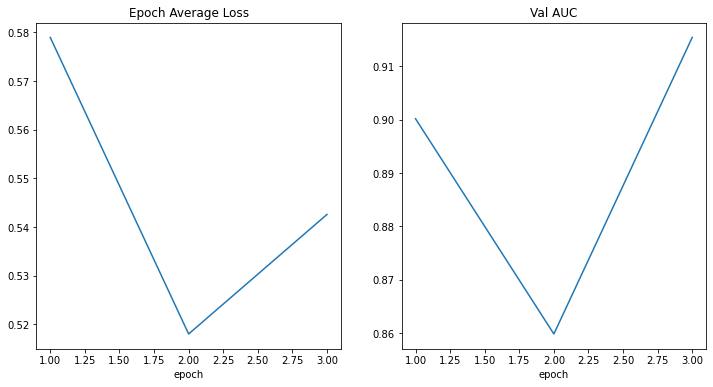

In [ ]:
plt.figure("train", (12, 6)) #
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))] #0부터 eppch_loss가 계산된 횟수까지 리스트에 저장
y = epoch_loss_values #epoch_loss값
plt.xlabel("epoch") #축은 epoch
plt.plot(x, y) 
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))] #0에서 epoch수까지 1을 더해서 가져와서 validation interval과 곱함
y = metric_values #epoch별 AUC값
plt.xlabel("epoch") #축은 epoch
plt.plot(x, y)
plt.show()


#Evaluate the model on test dataset

After training and validation, we already got the best model on validation test.
We need to evaluate the model on test dataset to check whether it's robust and not over-fitting.
We'll use these predictions to generate a classification report.

(training과 validation을 거친 후, 우리는 이미 validation 테스트에서 최고의 모델을 얻었습니다.
테스트 데이터셋에서 모델을 평가하여 견고하고 overfitting되지 않았는지 확인해야 합니다.
이러한 예측을 사용하여 classification를 생성하겠습니다.)

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (  #test_image와 test_label을 가져옴
            test_data[0].to(device),
            test_data[1].to(device),
        )
        
        test_images = test_images.reshape(test_images.shape[0], test_images.shape[3],test_images.shape[1],test_images.shape[2] )

        pred = model(test_images).argmax(dim=1) #차원에서 텐서의 최대값 인덱스를 반환합니다.
        for i in range(len(pred)):
            y_true.append(test_labels[i].item()) # 정답들을 저장
            y_pred.append(pred[i].item())        # 모델이 예측한 값들을 저장

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
pred

tensor([0, 1, 1, 2], device='cuda:0')

In [ ]:
y_true

[0,
 1,
 1,
 2,
 2,
 0,
 1,
 2,
 0,
 0,
 1,
 1,
 2,
 1,
 0,
 1,
 2,
 2,
 0,
 0,
 1,
 2,
 1,
 0,
 0,
 2,
 0,
 2,
 0,
 1,
 2,
 0,
 0,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 0,
 2,
 1,
 0,
 0,
 1,
 1,
 2]

In [ ]:
y_pred

[0,
 1,
 1,
 2,
 2,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 2,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 2,
 2,
 1,
 1,
 0,
 2,
 1,
 0,
 0,
 1,
 1,
 2]